# Requirements

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import scipy.stats as stats
import geoplot as gplt


from matplotlib.patches import Patch
import seaborn as sns
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

from functools import partial
from shapely.ops import transform
import pyproj

In [3]:
# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

In [4]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [5]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [6]:
LIRE = gpd.read_parquet("../data/large_data/LIREg_occupsorgs.parquet")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120),False,65,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tege

In [7]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")

# Spatial distribution of inscriptions by context

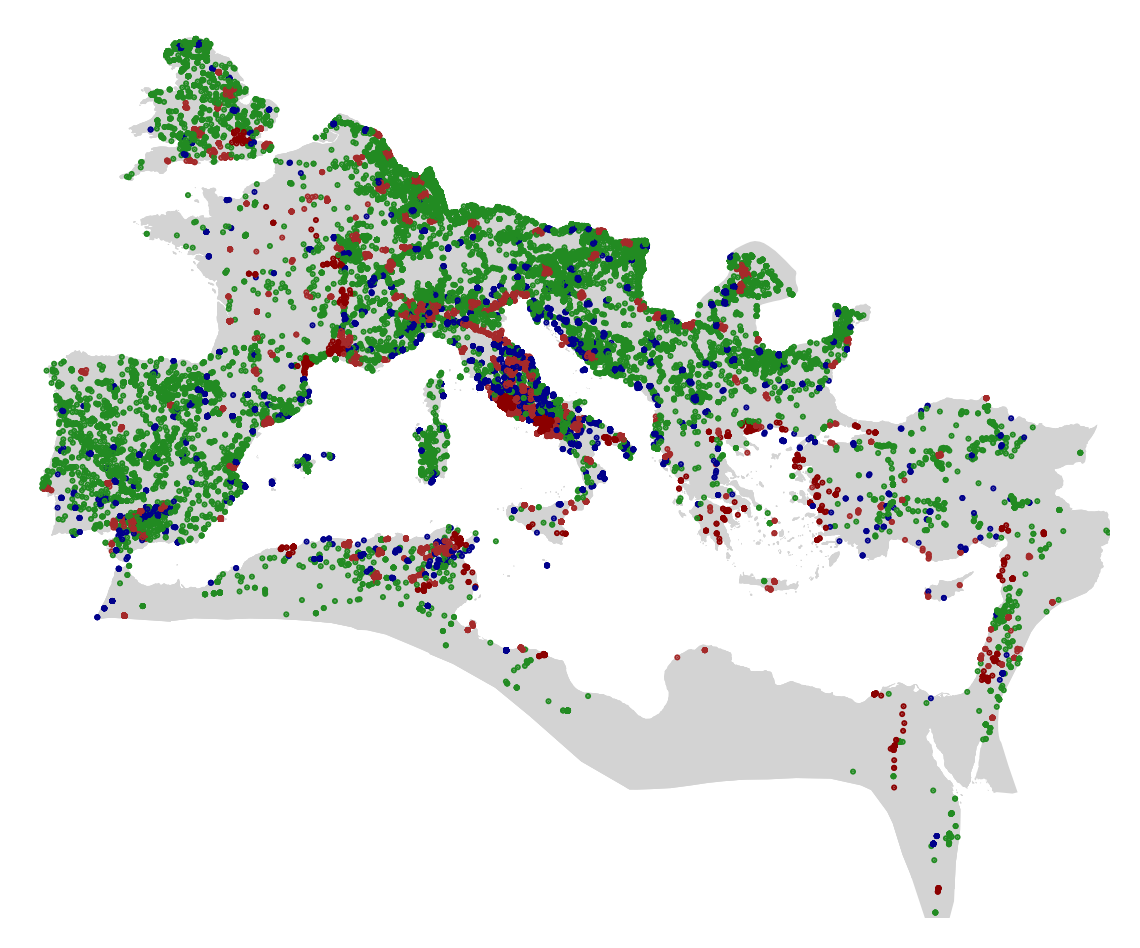

In [8]:
context_color_dict = {"large" : "darkred",
                      "medium" : "brown",
                      "small" : "darkblue",
                      "rural" : "forestgreen"}
colors = LIRE["urban_context_alt"].apply(lambda x: context_color_dict[x])

fig, ax = plt.subplots(figsize=(5.2,3.2), tight_layout=True)
pleiades_regions.plot(ax=ax, color="lightgray")
LIRE.plot(ax=ax, markersize=0.2, color=colors)
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)
plt.show()

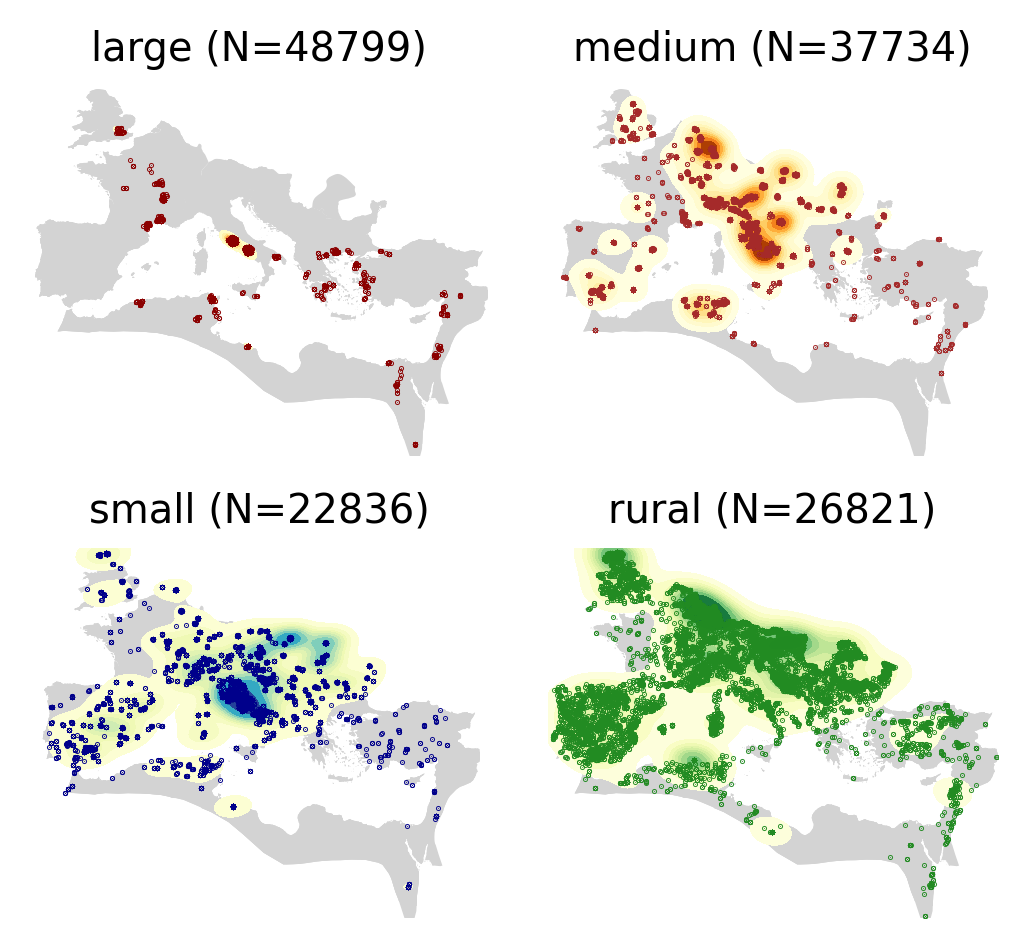

In [6]:
#color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
#colors: https://matplotlib.org/stable/gallery/color/named_colors.html
fig, axs = plt.subplots(2,2, figsize=(5.2,3.2), tight_layout=True)


for ax, context, color, cmap in zip(
        axs.ravel(),
        ["large", "medium", "small", "rural"],
        ["darkred", "brown", "darkblue","forestgreen"],
        ["YlOrRd", "YlOrBr", "YlGnBu", "YlGn"]):
    pleiades_regions.plot(ax=ax, color="lightgray")
    df = LIRE[LIRE["urban_context_alt"]==context]
    gplt.kdeplot(df, cmap=plt.get_cmap(cmap), ax=ax, shade=True, zorder=2)
    df.plot(ax=ax, marker=".", markersize=0.2, color=color, zorder=3)
    ax.set_axis_off()
    ax.set_xlim(-10, 41)
    ax.set_ylim(23, 55.5)
    ax.set_title(context + " (N={0})".format(str(len(df))))


In [39]:
save_figure(fig, "lire_spatial_by_context")

A file with the same name ("lire_spatial_by_context.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/lire_spatial_by_context.eps"
A file with the same name ("lire_spatial_by_context.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/lire_spatial_by_context.png"


# Occupations and organizations by context

In [9]:
# OCCUPATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.05010348572716654
medium 0.035591243970954575
small 0.03897355053424418
rural 0.018791245665709704


In [10]:
# OCCUPATIONS frequency accross location categories - WESTERN
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.049550195700731575
medium 0.03286161021890072
small 0.03314941320721668
rural 0.016069497781589052


In [10]:
# ORGANIZATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["organizations_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.0192626898092174
medium 0.01041501033550644
small 0.012830618321947802
rural 0.006226464337645875


In [11]:
# ORGANIZATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["organizations_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.019180720916412222
medium 0.009672973975724811
small 0.0104659309861622
rural 0.004511390328473957


# Closer look at urban contexts...

# Bootstrap test

bawed on Brezina 2018, p. 232, drawing on Lijffijt 2016
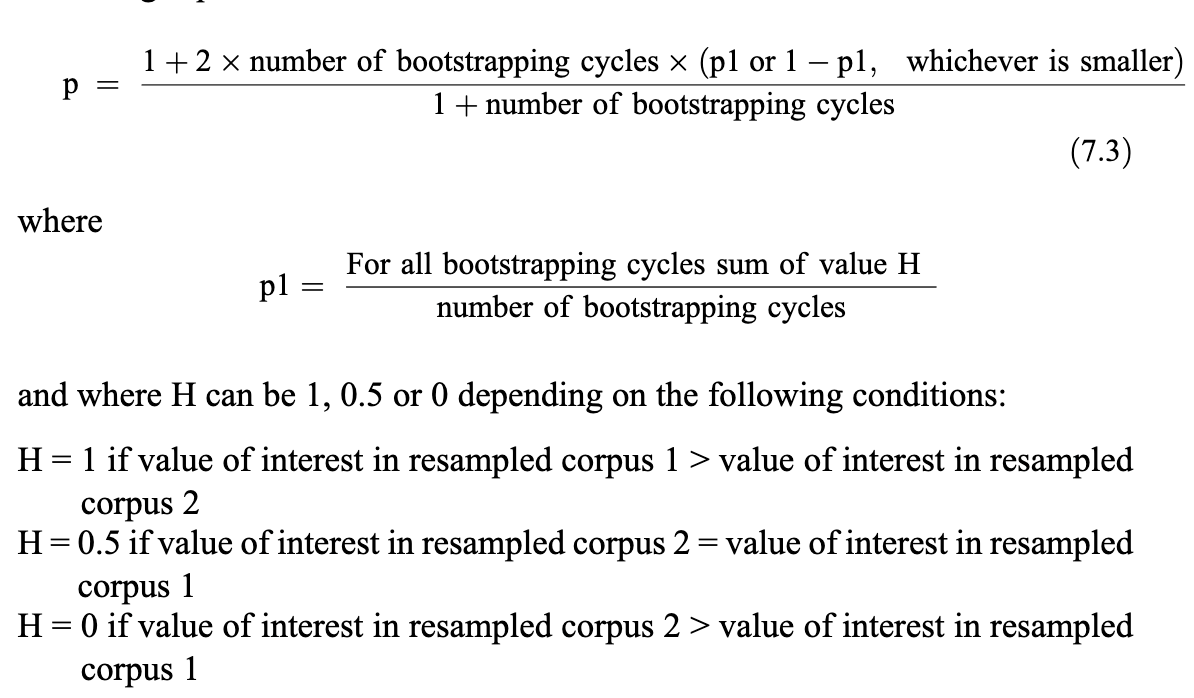

In [17]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, column, row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

### Occupations - alternative urban contexts

In [18]:
# LIRE - occupations URBAN vs RURAL areas
p, cohens_d, CI95, lire_occups_urban_rural = bootstrap_test(LIRE[~(LIRE["urban_context_alt"]=="rural")], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.011988011988011887, 0.08271260585466274, (4.0, 44.02499999999998))

In [19]:
# LIRE - occupations LARGE vs MEDIUM city areas
p, cohens_d, CI95, lire_occups_large_medium = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="large"], LIRE[LIRE["urban_context_alt"]=="medium"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.26373626373626363, 0.04551278201112305, (-12.0, 41.0))

In [20]:
# LIRE - occupations SMALL vs RURAL areas
p, cohens_d, CI95, lire_occups_small_rural = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="small"], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.038961038961038995, 0.08468160218176007, (1.0, 38.0))

## Box plot

In [21]:
labels=[
    "large city",
    "medium city",
    "small city",
    "rural area"
]

In [22]:
labels * 2

['large city',
 'medium city',
 'small city',
 'rural area',
 'large city',
 'medium city',
 'small city',
 'rural area']

In [23]:
len(lire_occups_large_medium + lire_occups_small_rural)

4

In [24]:
stat_series = []
for label, data in zip(labels, lire_occups_large_medium + lire_occups_small_rural):
    stat_series.append(pd.Series(data).describe())

In [28]:
contexts = labels
measurements = ["occups. per 1,000 ins."] * 4

occups_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_contexts_descriptive[col] = occups_contexts_descriptive[col].astype(int)
occups_contexts_descriptive.drop("count", inplace=True, axis=1)
occups_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_contexts_descriptive = occups_contexts_descriptive.round(2)
occups_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",large city,49.78,9.80,18,43,49,56,85
1,"occups. per 1,000 ins.",medium city,35.69,8.24,17,30,35,40,72
2,"occups. per 1,000 ins.",small city,39.08,7.56,15,34,39,44,69
3,"occups. per 1,000 ins.",rural area,18.84,5.26,5,15,18,22,38


In [29]:
print(occups_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
           measurement &     context &  mean &  std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
occups. per 1,000 ins. &  large city & 49.78 & 9.80 &   18 &   43 &   49 &   56 &   85 \\
occups. per 1,000 ins. & medium city & 35.69 & 8.24 &   17 &   30 &   35 &   40 &   72 \\
occups. per 1,000 ins. &  small city & 39.08 & 7.56 &   15 &   34 &   39 &   44 &   69 \\
occups. per 1,000 ins. &  rural area & 18.84 & 5.26 &    5 &   15 &   18 &   22 &   38 \\
\bottomrule
\end{tabular}



In [30]:
occups_contexts_descriptive.to_csv("../data/occups_contexts_descriptive.csv")

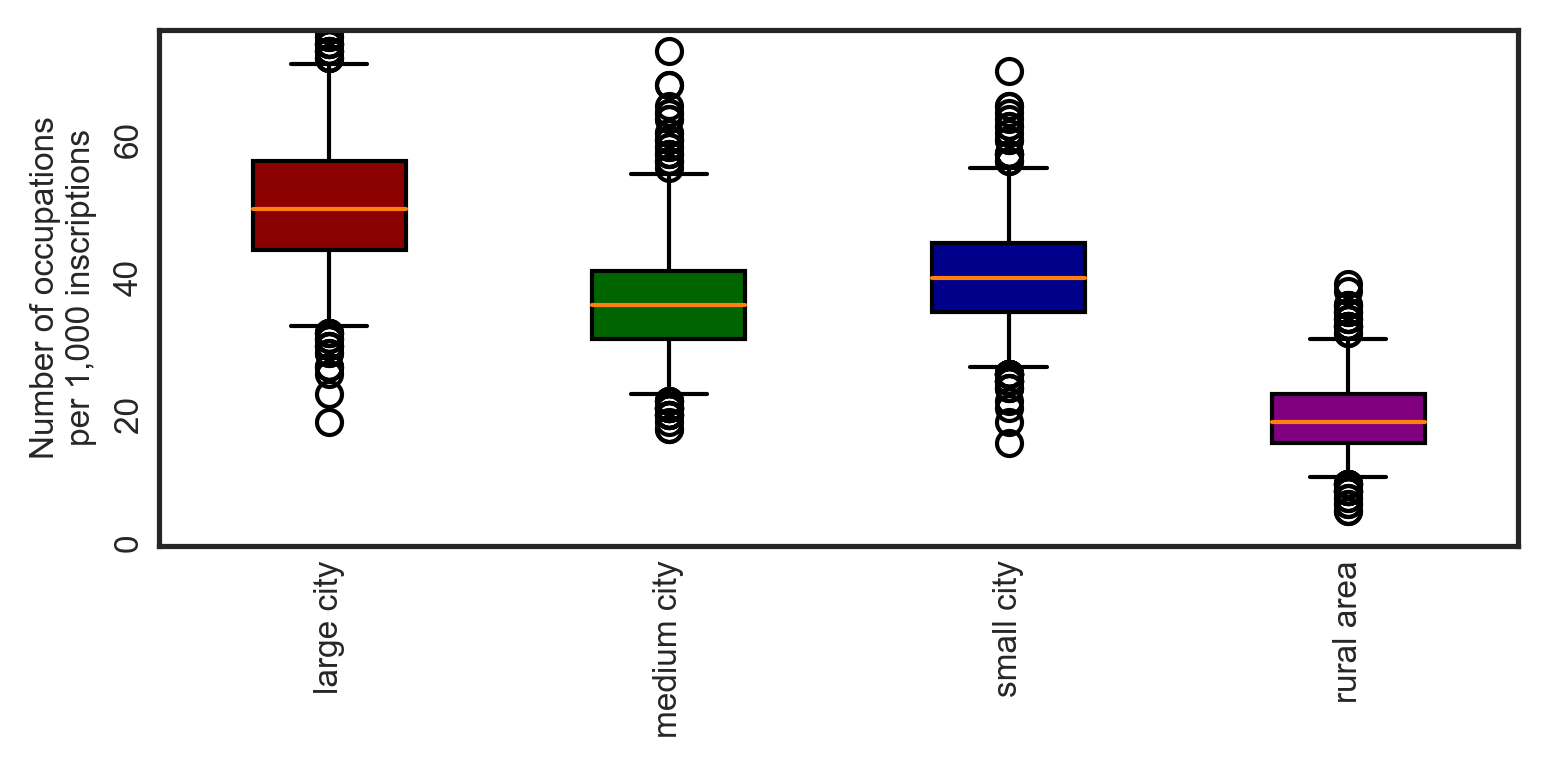

In [37]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax1 = plt.subplots(figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot(lire_occups_large_medium + lire_occups_small_rural, whis=[2.5, 97.5], labels=labels,
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 75)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue", "purple"]
#for bplot in bplot1:
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

In [38]:
save_figure(fig, "occups_by_context_box")

A file with the same name ("occups_by_context_box.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_by_context_box.eps"
A file with the same name ("occups_by_context_box.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_by_context_box.png"


# By industry type

In [39]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [40]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIRE["occups"] = LIRE["occups"].apply(list)
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

## alternative urban contexts

In [41]:
edhcs_occups_cats_data = {}
contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Metal-Working', 'Miscellaneous Services', 'Building', 'Food-Production', 'Education', 'Retail', 'Clothing', 'Transport', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Glass-Working', 'Unclear meaning', 'Fuel / Raw material'] [9.6295840511937, 6.260767905488555, 5.891582574452375, 2.8150381491508734, 2.1843465419640657, 2.1689638198375585, 2.1381983755845435, 1.8920748215604233, 1.1998523258675855, 1.122938715235048, 0.5845434408072853, 0.5076298301747477, 0.4922471080482402, 0.38456805316268766, 0.16920994339158257, 0.10767905488555254, 0.046148166379522515, 0.015382722126507506] 37.610755599310856
['Metal-Working', 'Managerial', 'Miscellaneous Services', 'Retail', 'Clothing', 'Performing Arts', 'Building', 'Food-Production', 'Education', 'Transport', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Unclear meaning', 'Glass-Working'] [8.18125930618246, 6.171007019520484, 3.7633792808

In [42]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Clothing': [1.8920748215604233,
  2.1738774727856254,
  2.7590253306464847,
  0.8125677139761648],
 'Education': [2.1689638198375585,
  1.1687513294546372,
  1.3271261084122332,
  0.45142650776453597],
 'Transport': [1.1998523258675855,
  0.7713758774400605,
  0.9080336531241597,
  0.5718069098350789],
 'Retail': [2.1381983755845435,
  3.4828789617748193,
  0.8032605393021413,
  1.0834236186348862],
 'Metal-Working': [6.260767905488555,
  8.18125930618246,
  10.267765154557805,
  4.815216082821716],
 'Miscellaneous Services': [5.891582574452375,
  3.763379280843932,
  2.828874073194497,
  2.527988443481401],
 'Food-Production': [2.1843465419640657,
  1.3090014889891939,
  0.6984874254801228,
  0.45142650776453597],
 'Managerial': [9.6295840511937,
  6.171007019520484,
  7.4039667100893025,
  2.2872276393403155],
 'Building': [2.8150381491508734,
  1.3323765155782865,
  1.8509916775223256,
  1.4746599253641506],
 'Performing Arts': [1.122938715235048,
  1.3557515421673794,
  1.3620504

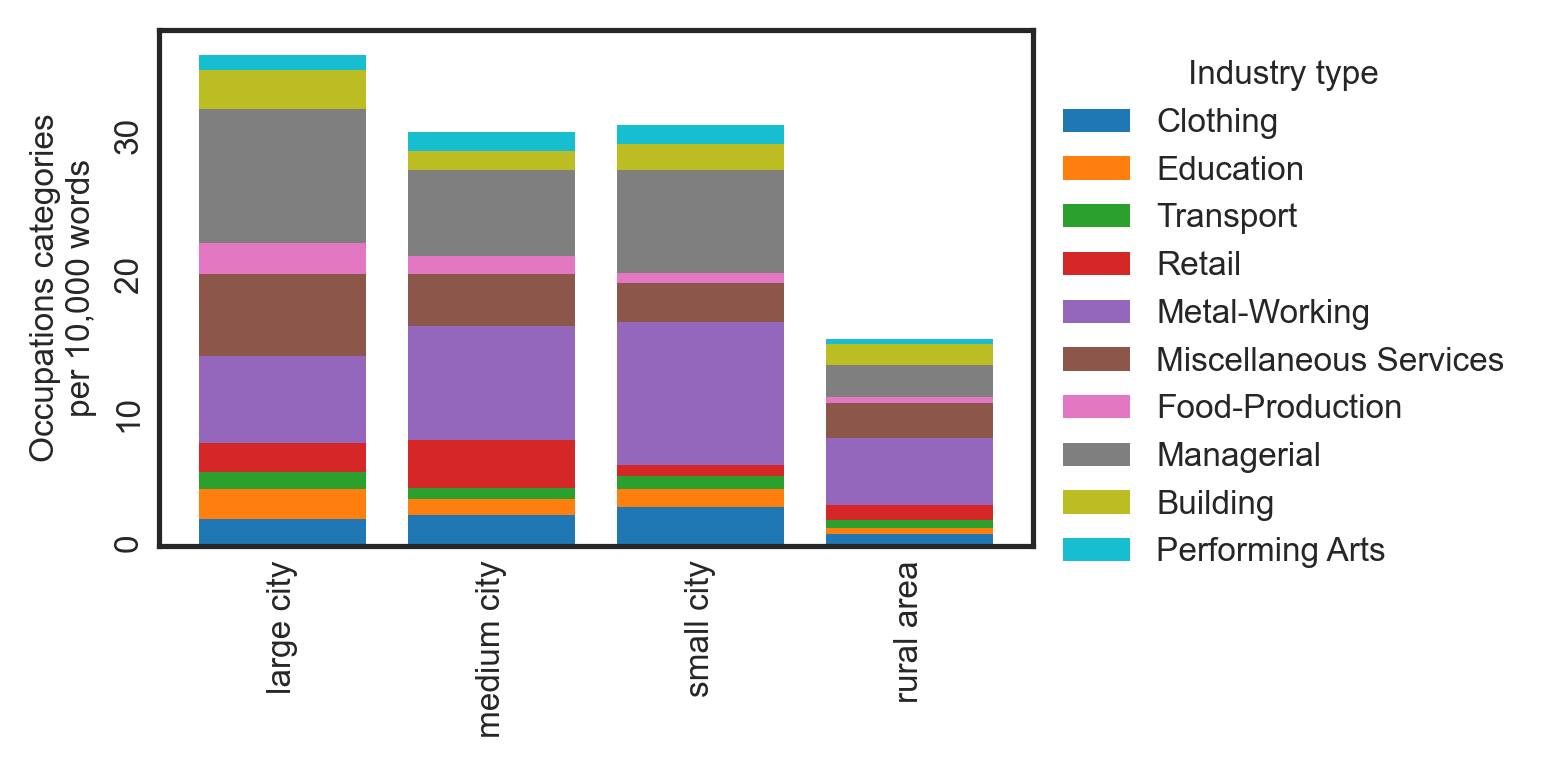

In [43]:
fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
first_bar_cat = list(edhcs_data_by_category.keys())[0]
ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in list(edhcs_data_by_category.keys())[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")

ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

In [44]:
save_figure(fig, "occups_industrytypes_harris_bar")

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_harris_bar.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_harris_bar.png"


## Hisco categories

In [45]:
occupations_df["Term"] = occupations_df["Term"].apply(lambda x: x.replace(" ", "_"))

In [46]:
hisco_cats_dict = {
    0.0 : "Professional, technical and related workers",
    1.0 : "Professional, technical and related workers",
    2.0 : "Administrative and managerial workers",
    3.0 : "Clerical and related workers",
    4.0 : "Sales workers",
    5.0 : "Service workers",
    6.0 : "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    7.0 : "Production and related workers, transport equipment operators and labourers",
    8.0 : "Production and related workers, transport equipment operators and labourers",
    9.0 : "Production and related workers, transport equipment operators and labourers",
}

In [47]:
hisco_cats_labels = list(set(hisco_cats_dict.values())) + ["unclassified"]
hisco_cats_labels

['Administrative and managerial workers',
 'Service workers',
 'Professional, technical and related workers',
 'Clerical and related workers',
 'Production and related workers, transport equipment operators and labourers',
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
 'Sales workers',
 'unclassified']

In [48]:
def hisco_literary(hisco_code):
    try:
        return hisco_cats_dict[float(hisco_code)]
    except:
        return "unclassified"
occupations_df["hisco_cats"] = occupations_df["HISCO_majorgroup"].apply(hisco_literary)

In [49]:
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["hisco_cats"]))
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

In [50]:
edhcs_occups_cats_data = {}

contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Service workers', 'Clerical and related workers', 'Sales workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [12.736893920748216, 9.475756829928624, 5.168594634506523, 3.430347034211174, 2.707359094265321, 2.5381491508737386, 0.938346049716958, 0.046148166379522515] 37.04159488063008
['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Sales workers', 'Clerical and related workers', 'Service workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [13.2068900228374, 5.913881727040465, 4.301004892393065, 3.810129334022118, 1.940127206894698, 1.3557515421673794, 0.7012507976727823, 0.023375026589092743] 31.2524

In [51]:
edhcs_occups_cats_data

{'large city': {'categories': ['Production and related workers, transport equipment operators and labourers',
   'Administrative and managerial workers',
   'Professional, technical and related workers',
   'Service workers',
   'Clerical and related workers',
   'Sales workers',
   'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
   'unclassified'],
  'freqs': [12.736893920748216,
   9.475756829928624,
   5.168594634506523,
   3.430347034211174,
   2.707359094265321,
   2.5381491508737386,
   0.938346049716958,
   0.046148166379522515],
  'cat_freq_dict': {'Production and related workers, transport equipment operators and labourers': 12.736893920748216,
   'Administrative and managerial workers': 9.475756829928624,
   'Professional, technical and related workers': 5.168594634506523,
   'Service workers': 3.430347034211174,
   'Clerical and related workers': 2.707359094265321,
   'Sales workers': 2.5381491508737386,
   'Agricultural, animal husbandry and fo

In [52]:
hisco_cats_labels = [
    "Professional, technical and related workers",
    "Administrative and managerial workers",
    "Clerical and related workers",
    "Sales workers",
    "Service workers",
    "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    "Production and related workers, transport equipment operators and labourers",
    "unclassified"
]

In [53]:
edhcs_data_by_category = {}
for cat in hisco_cats_labels:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Professional, technical and related workers': [5.168594634506523,
  4.301004892393065,
  3.5972102412226326,
  1.8358011315757796],
 'Administrative and managerial workers': [9.475756829928624,
  5.913881727040465,
  7.299193596267283,
  2.2872276393403155],
 'Clerical and related workers': [2.707359094265321,
  1.940127206894698,
  1.7811429349743133,
  0.5417118093174431],
 'Sales workers': [2.5381491508737386,
  3.810129334022118,
  0.9778823956721718,
  1.203804020705429],
 'Service workers': [3.430347034211174,
  1.3557515421673794,
  0.8731092818501536,
  0.331046105693993],
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters': [0.938346049716958,
  0.7012507976727823,
  0.38416808401406755,
  0.27085590465872156],
 'Production and related workers, transport equipment operators and labourers': [12.736893920748216,
  13.2068900228374,
  16.135059528590837,
  8.697484049596726],
 'unclassified': [0.046148166379522515, 0.023375026589092743, 0, 0]}

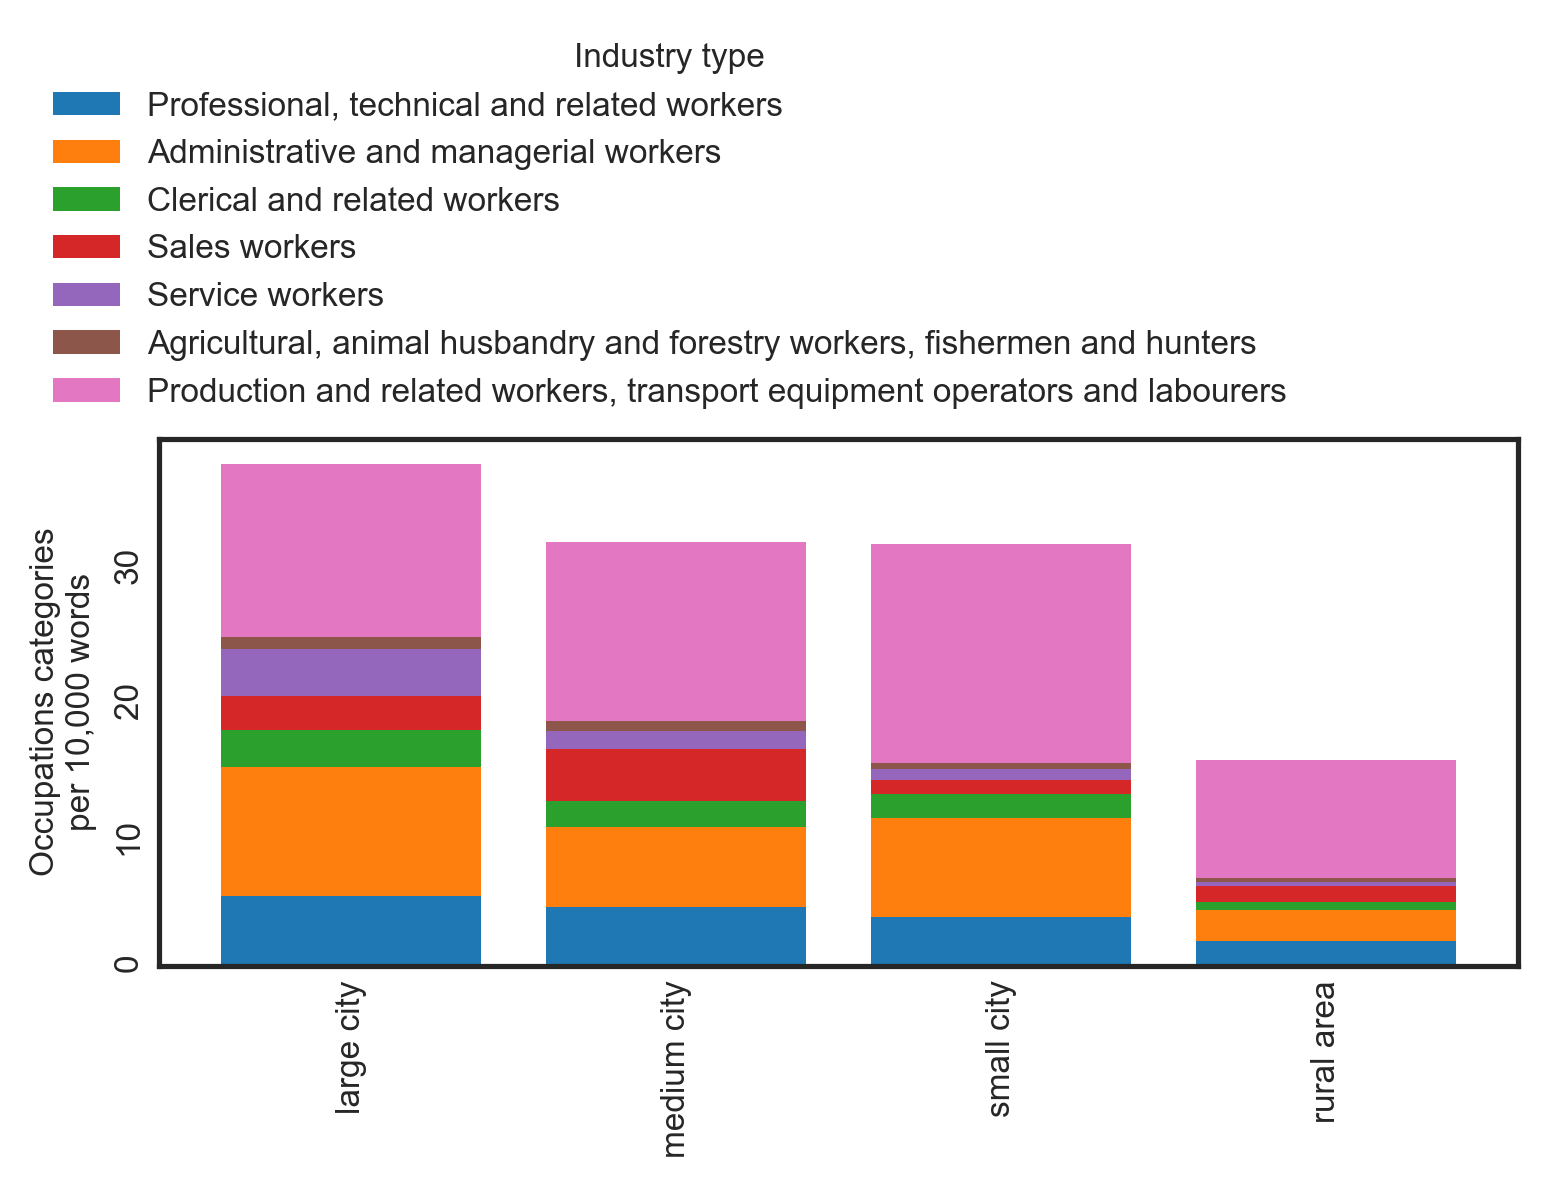

In [55]:
fig, ax = plt.subplots(figsize=[5.2,4], tight_layout=True)
first_bar_cat = hisco_cats_labels[0]

ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in hisco_cats_labels[1:-1]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(-0.1, 1), loc="lower left", fontsize=8)

In [56]:
save_figure(fig, "occups_industrytypes_hisco_bar")

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_hisco_bar.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_hisco_bar.png"


In [58]:
LIRE.to_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")